# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from collections import deque
import math
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x):
    tar_count = Counter(x)
    G = 0
    len_x = len(x)
    for c in tar_count.values():
        G += (c/len_x)*(1-c/len_x)
    return G
        
    
def entropy(x):
    tar_count = Counter(x)
    E = 0
    len_x = len(x)
    for c in tar_count.values():
        E += (c/len_x)*(math.log2(c/len_x))
    return E

def gain(left_y, right_y, criterion):
    tars = list(left_y) + list(right_y)
    old = criterion(tars)
    new = (len(left_y)*criterion(left_y)+len(right_y)*criterion(right_y))/len(tars)
    return old-new

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [3]:
class DecisionTreeLeaf:
    def __init__(self):
        self.y = None

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = None
        self.split_value = None
        self.left = None
        self.right = None

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [4]:
class DecisionTreeClassifier:
    def __init__(self, criterion='gini', max_depth=None, min_samples_leaf=1):
        self.root = None
        self.depth = 1
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    
    def test_split(self, feat, value, X):
        left, right = [], []
        for row in X:
            if row[feat] < value:
                left.append(row)
            else:
                right.append(row)
        return np.asarray(left), np.asarray(right)

    def get_split(self, X):
        best_feat, best_value, best_gain, best_left, best_right = None, None, -float('inf'), None, None
        for feat in range(X.shape[1]-1):
            for row in X:
                left, right = self.test_split(feat, row[feat], X)
                if len(left) == 0 or len(right) == 0:
                    continue
                gain_cur = gain(left[:,-1], right[:,-1], gini if self.criterion == 'gini' else entropy)
                if gain_cur > best_gain:
                    best_feat, best_value, best_gain, best_left, best_right = feat, row[feat], gain_cur, left, right
        if best_feat == None:
            return {'feat': feat, 'value': row[feat], 'left': left, 'right': right}
        else:
            return {'feat': best_feat, 'value': best_value, 'left': best_left, 'right': best_right}
    
    def probs(self, subset, var):
        labels = [row[-1] for row in subset]
        if var == 1:
            return [[0, labels.count(0)/len(subset)],
                   [1, labels.count(1)/len(subset)]]
        else:
            return [[0, labels.count(1)/len(subset)],
                   [1, labels.count(0)/len(subset)]]
        
    
    def get_tree(self, node, depth):
        if len(node['left']) == 0:
            node['left'] = self.probs(node['right'], 0)
            node['right'] = self.probs(node['right'], 1)
            return
        elif len(node['right']) == 0:
            node['right'] = self.probs(node['left'], 0)
            node['left'] = self.probs(node['left'], 1)
            return    
        if depth == self.max_depth:
            node['left'] = self.probs(node['left'], 1)
            node['right'] = self.probs(node['right'], 1)
            return
        if len(node['left']) <= self.min_samples_leaf:
            node['left'] = self.probs(node['left'], 1)
        else:
            if list(node['left'][:,-1]).count(1) == 0 or list(node['left'][:,-1]).count(0) == 0:
                node['left'] = self.probs(node['left'], 1)
            else:
                node['left'] = self.get_split(node['left'])
                self.get_tree(node['left'], depth+1)
        if len(node['right']) <= self.min_samples_leaf:
            node['right'] = self.probs(node['right'], 1)
        else:
            if list(node['right'][:,-1]).count(1) == 0 or list(node['right'][:,-1]).count(0) == 0:
                node['right'] = self.probs(node['right'], 1)
            else:
                node['right'] = self.get_split(node['right'])
                self.get_tree(node['right'], depth+1)
    
    
    def fit(self, X):
        root = self.get_split(X)
        self.get_tree(root, self.depth)
        return root
        
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('%s[X%d < %.3f]' % ((depth*' ', (node['feat']+1), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node)))
        
                
        
    
    def predict_proba(self, X, root):
        proba = []
        for row in X:
            node = root
            while isinstance(node, dict):
                if row[node['feat']] < node['value']:
                    node = node['left']
                else:
                    node = node['right']
            proba.append({node[0][0]: node[0][1],
                          node[1][0]: node[1][1]})
        return proba
            
                
    
    def predict(self, X, root):
        proba = self.predict_proba(X, root)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

Для двух из трёх метрик построение деревьев даёт более высокие результаты, чем K_NN. В целом, деревья выглядят более точным методом классификации, так как на каждом шаге обучения мы выбираем лучшую фичу, а также её значение, при котором наиболее выгодно можно разбить датасет. В K_NN же мы просто ищем расстояния между всеми признаками. Также K_NN требует скейлинг, а деревья нет.

P. S. Я что-то не очень разобрался с предложенными функциями зарисовки дерева, поэтому привёл свой вариант. В целом, логику по нему также можно проследить.

In [7]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = [1 if i == 'M' else 0 for i in df['label']]
    return np.asarray(df.drop("label", axis=1)), np.asarray(y)

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv, header=0)
    y = df["label"]
    return np.asarray(df.drop("label", axis=1)), np.asarray(y.values)

In [8]:
Cancer_path = 'cancer.csv'
Spam_path = 'spam.csv'

In [9]:
X_cancer, y_cancer = read_cancer_dataset(Cancer_path)
X_spam, y_spam = read_spam_dataset(Spam_path)

## Spam

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, train_size = 0.1)

In [11]:
Spam_train = np.concatenate([X_train, y_train[:,None]], axis=1)

Precision= 0.8008036739380023
Recall= 0.8579335793357934
Accuracy= 0.8604201883602994


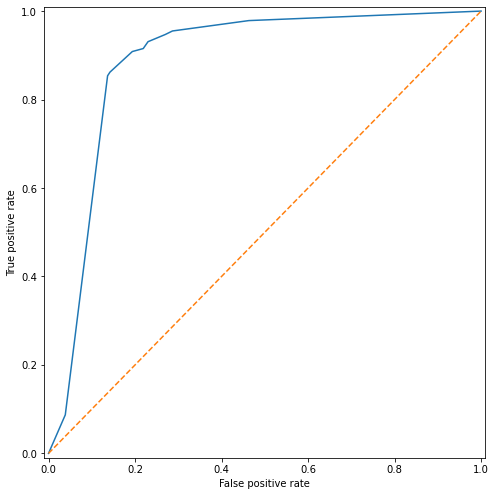

[X52 < 0.082]
 [X7 < 0.050]
  [X53 < 0.124]
   [X16 < 0.920]
    [X4 < 19.730]
     [[[0, 0.9583333333333334], [1, 0.041666666666666664]]]
     [[[0, 0.0], [1, 1.0]]]
    [[[0, 0.3333333333333333], [1, 0.6666666666666666]]]
   [[[0, 0.2857142857142857], [1, 0.7142857142857143]]]
  [[[0, 0.17391304347826086], [1, 0.8260869565217391]]]
 [X55 < 2.593]
  [X16 < 0.370]
   [X19 < 2.530]
    [X5 < 0.750]
     [[[0, 1.0], [1, 0.0]]]
     [[[0, 0.25], [1, 0.75]]]
    [[[0, 0.4117647058823529], [1, 0.5882352941176471]]]
   [[[0, 0.17391304347826086], [1, 0.8260869565217391]]]
  [X35 < 0.220]
   [X37 < 0.260]
    [X12 < 2.560]
     [[[0, 0.017857142857142856], [1, 0.9821428571428571]]]
     [[[0, 1.0], [1, 0.0]]]
    [[[0, 0.4], [1, 0.6]]]
   [[[0, 0.75], [1, 0.25]]]


In [13]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
root = tree.fit(Spam_train)
y_pred = tree.predict(X_test, root)
print('Precision=', str(precision_score(y_test, y_pred)))
print('Recall=', str(recall_score(y_test, y_pred)))
print('Accuracy=', str(accuracy_score(y_test, y_pred)))
plot_roc_curve(y_test, tree.predict_proba(X_test, root))
tree.print_tree(root)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(X_spam), y_spam, train_size = 0.1)
K_NN = KNeighborsClassifier()
K_NN.fit(X_train, y_train)
y_pred = K_NN.predict(X_test)
print('Precision=', str(precision_score(y_test, y_pred)))
print('Recall=', str(recall_score(y_test, y_pred)))
print('Accuracy=', str(accuracy_score(y_test, y_pred)))

Precision= 0.8546831955922864
Recall= 0.7641625615763546
Accuracy= 0.8565563873460517


## Cancer

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, train_size = 0.1)

In [16]:
Cancer_train = np.concatenate([X_train, y_train[:,None]], axis=1)

Precision= 0.883248730964467
Recall= 0.883248730964467
Accuracy= 0.9103313840155945


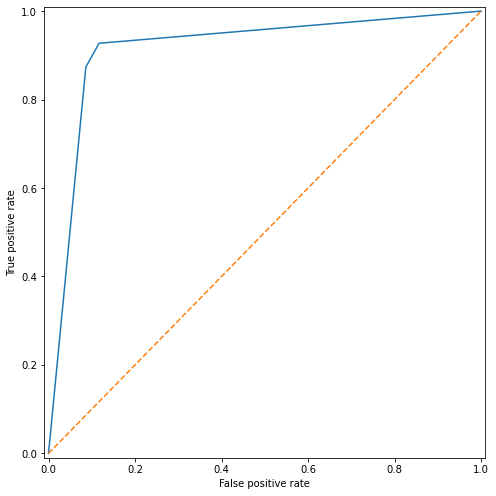

[X23 < 109.500]
 [X5 < 0.128]
  [X22 < 33.370]
   [[[0, 1.0], [1, 0.0]]]
   [[[0, 0.6666666666666666], [1, 0.3333333333333333]]]
  [[[0, 0.0], [1, 1.0]]]
 [[[0, 0.0], [1, 1.0]]]


In [17]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
root = tree.fit(Cancer_train)
y_pred = tree.predict(X_test, root)
print('Precision=', str(precision_score(y_test, y_pred)))
print('Recall=', str(recall_score(y_test, y_pred)))
print('Accuracy=', str(accuracy_score(y_test, y_pred)))
plot_roc_curve(y_test, tree.predict_proba(X_test, root))
tree.print_tree(root)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(X_cancer), y_cancer, train_size = 0.1)
K_NN = KNeighborsClassifier()
K_NN.fit(X_train, y_train)
y_pred = K_NN.predict(X_test)
print('Precision=', str(precision_score(y_test, y_pred)))
print('Recall=', str(recall_score(y_test, y_pred)))
print('Accuracy=', str(accuracy_score(y_test, y_pred)))

Precision= 0.9636363636363636
Recall= 0.8412698412698413
Accuracy= 0.9298245614035088
